In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import os
import cv2

# load labelled data 
def load_labelled_dataset(path):
    data = load_files(path)
    classified_files = np.array(data['filenames'])
    return classified_files

#load unlabelled data
def load_unlabelled_dataset(path):
    images = []
    for dirpath, subdirs, files in os.walk(path):
        for name in files: 
            if name.endswith(".jpg"):
                images.append(os.path.join(dirpath, name))
    return images

# load datasets. labelled files will be used 
labelled_files = load_labelled_dataset('imgs/train')
unlabelled_files = load_unlabelled_dataset('imgs/test')

# load list of class names
categories = [item[20:-1] for item in sorted(glob("imgs/train/*/"))]

# print statistics about the dataset
print('There are %d total categories.' % len(categories))
print('There are %s total  images.\n' % len(np.hstack([labelled_files, unlabelled_files])))
print('There are %d labelled images.' % len(labelled_files))
print('There are %d unlabelled images.'% len(unlabelled_files))

Using TensorFlow backend.


There are 10 total categories.
There are 102150 total  images.

There are 22424 labelled images.
There are 79726 unlabelled images.


In [2]:
import pandas as pd

# Read informationabout images and their labels from .csv file
def get_driver_data():
    df = pd.read_csv('driver_imgs_list.csv')    
    return df

import numpy as np

# Match images with their labels and return them as two arrays.
def match_labels_images(img_paths):
    df = get_driver_data()
    images = []
    labels = []
    for img_path in img_paths:
        image = img_path.split("/")
        im_name = image[-1]
        label = df['classname'][df['img']==im_name]
        str_label = str(label)
        images.append(img_path)
        labels.append(str_label)
    np_images = np.array(images)
    np_labels = np.array(labels)
    
    return np_images, np_labels

X_labelled, y_labelled = match_labels_images(labelled_files)

print(X_labelled.shape[0], 'labelled samples')

22424 labelled samples


In [3]:
from sklearn.model_selection import train_test_split

# split labelled data into train, test and validation 
X_trainVal, X_test, y_trainVal, y_test = train_test_split(X_labelled, y_labelled, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_trainVal, y_trainVal, test_size=0.2)

# print number of training, validation, and test images
print(X_train.shape[0], 'train samples')
print(X_validation.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

14351 train samples
3588 validation samples
4485 test samples


In [4]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path,grayscale=True, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 1)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 1) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [5]:
# reshape label values into numerical values 0,1,2,3,4,5,7,8 and 9
def split_target(y_labels):
    y_val =[]

    for y in y_labels:
        y = y.split("c")
        y = y[1].split("\n")
        y_val.append(y[0])
    return y_val

In [6]:
from keras.utils import np_utils

# reshape labelled data to match input and output shape of the model
def reshape_labelled(X , y):
      
    data = np.array(paths_to_tensor(X), dtype=np.uint8)
    target = np.array(split_target(y), dtype=np.uint8)
    target = np_utils.to_categorical(target, 10)

    #Rescaling images by dividing every pixel in every image by 255
    data = data.astype('float32') / 255
    
    return data, target

# reshape unlabelled data, match the input shape of the model. This data will be used to predict on unlabelled 
#  data using our model
def reshape_unlabelled(X):
    
    data = np.array(paths_to_tensor(X), dtype=np.uint8)  

    #Rescaling images by dividing every pixel in every image by 255
    data = data.astype('float32') / 255
    
    return data

X_train, y_train = reshape_labelled(X_train , y_train)
X_validation, y_validation = reshape_labelled(X_validation , y_validation)
X_test, y_test = reshape_labelled(X_test , y_test)

#we select some sample of unlabelled data to plot and see how our model does on unlabelled data
X_unlabelled = reshape_unlabelled(unlabelled_files[:100])

# print shape of training, validation and test.
print('X_train shape:', X_train.shape)
print('X_validation shape:', X_validation.shape)
print('X_test shape:', X_test.shape)
# print number of training, validation, and test images
print(X_train.shape[0], 'train samples')
print(X_validation.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

# print shape of unlabelled set
print('X_unlabelled shape:', X_unlabelled.shape)

# print number of unlabelled images
print(X_unlabelled.shape[0], 'unlabelled samples')

100%|██████████| 100/100 [00:00<00:00, 119.41it/s]

X_train shape: (14351, 224, 224, 1)
X_validation shape: (3588, 224, 224, 1)
X_test shape: (4485, 224, 224, 1)
14351 train samples
3588 validation samples
4485 test samples
X_unlabelled shape: (100, 224, 224, 1)
100 unlabelled samples


In [7]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

# constructing the model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same',activation='relu',input_shape=(224, 224,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128,kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=16,kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0,3))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       16512     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        16416     
__________

In [8]:
#compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
from keras.callbacks import ModelCheckpoint 
# creating a checkpointer to save model results
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

In [10]:
#fitting the model
hist = model.fit(X_train, y_train, batch_size=32, epochs=10,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer], 
          verbose=1, shuffle=True)

Train on 14351 samples, validate on 3588 samples
Epoch 1/10
14351/14351 [==============================] - 96s - loss: 2.0803 - acc: 0.2054 - val_loss: 1.8448 - val_acc: 0.2993
Epoch 2/10
14351/14351 [==============================] - 90s - loss: 1.6198 - acc: 0.4135 - val_loss: 1.6515 - val_acc: 0.4345
Epoch 3/10
14351/14351 [==============================] - 91s - loss: 1.2145 - acc: 0.6022 - val_loss: 1.0811 - val_acc: 0.6639
Epoch 4/10
14351/14351 [==============================] - 90s - loss: 0.8704 - acc: 0.7374 - val_loss: 0.8630 - val_acc: 0.7467
Epoch 5/10
14351/14351 [==============================] - 90s - loss: 0.6550 - acc: 0.8080 - val_loss: 0.5883 - val_acc: 0.8311
Epoch 6/10
14351/14351 [==============================] - 91s - loss: 0.5221 - acc: 0.8459 - val_loss: 0.5067 - val_acc: 0.8590
Epoch 7/10
14351/14351 [==============================] - 90s - loss: 0.4265 - acc: 0.8783 - val_loss: 0.5988 - val_acc: 0.8278
Epoch 8/10
14351/14351 [==============================]

In [11]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best.hdf5')

In [12]:
# evaluate and print test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.921070234114


In [13]:
# get predictions on the test set
y_hat = model.predict(X_test)

In [14]:
from sklearn.metrics import log_loss
#Calculate logloss
log_loss = log_loss(y_test, y_hat)
print('\n', 'Log loss:', log_loss)


 Log loss: 0.321802023058


In [15]:
# define text labels to be used when plotting the data
safe_driving_labels = ['safe driving', 'texting - right', 'talking on the phone - right', 
                        'texting - left', 'talking on the phone - left', 'operating the radio', 
                       'drinking', 'reaching behind', 'hair and make-up', 'talking to passenger']

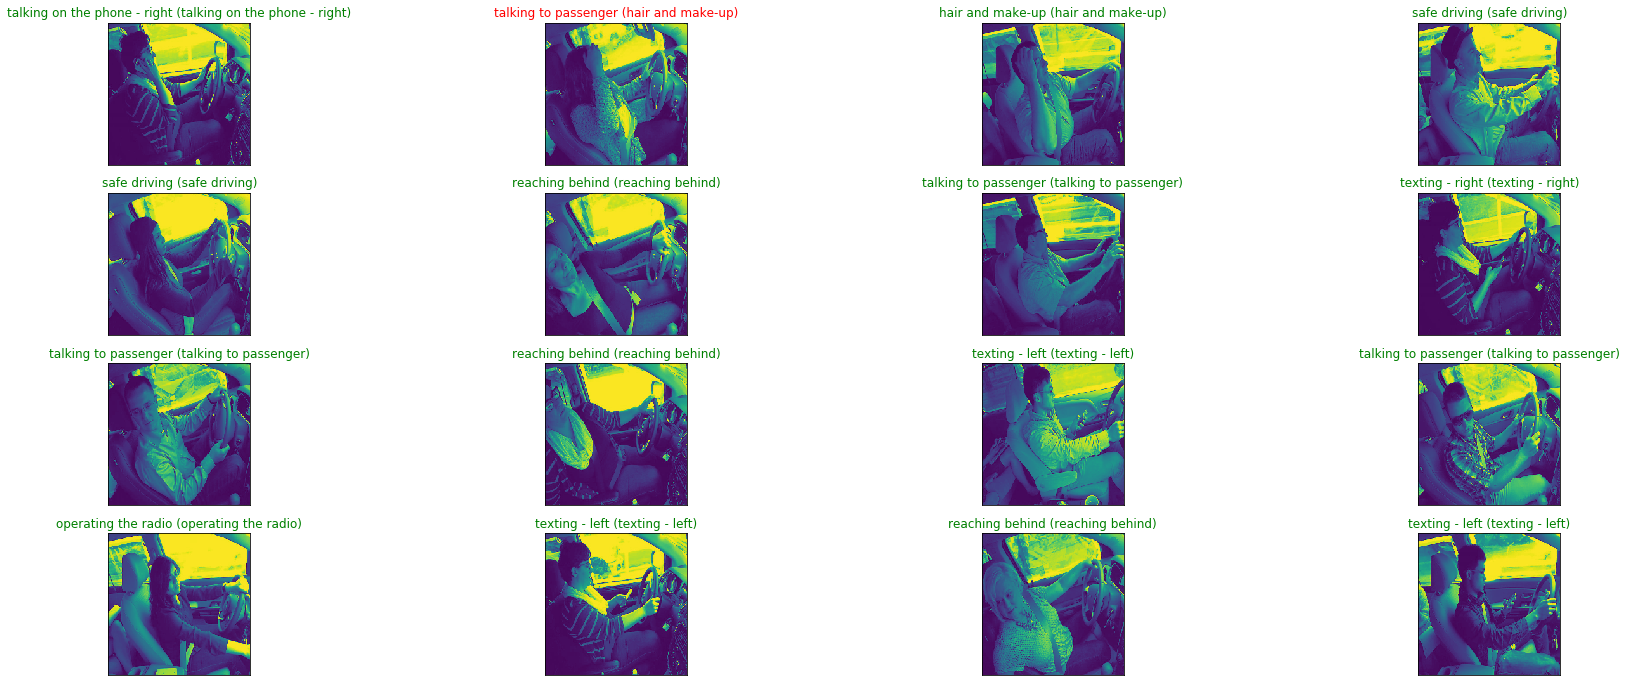

In [16]:
# plot a random sample of test images, their predicted labels, and ground truth
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(30, 12))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(safe_driving_labels[pred_idx], safe_driving_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [18]:
# get predictions on the unlabelled set
y_unlabelled = model.predict(X_unlabelled)

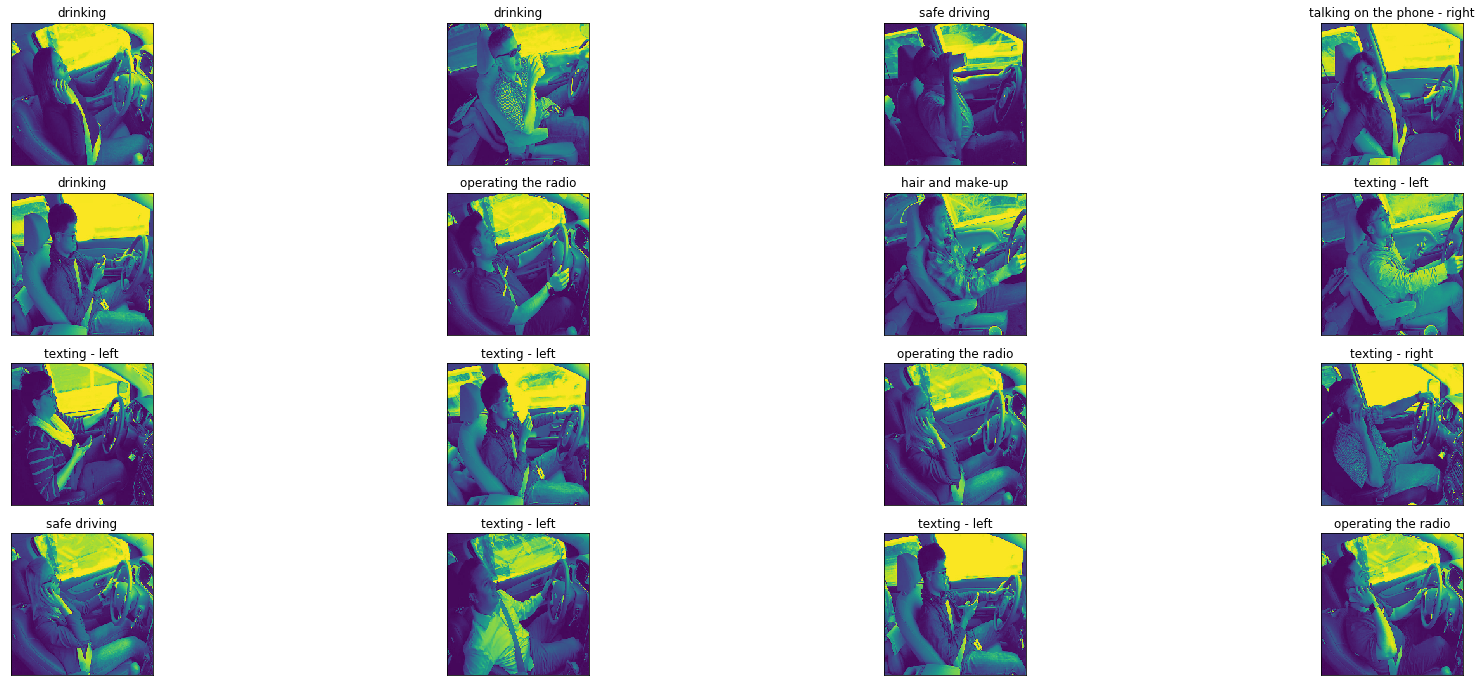

In [19]:
fig = plt.figure(figsize=(30, 12))
# plot a random sample predicted unlabelled images and predicted labels of those images.
for i, idx in enumerate(np.random.choice(X_unlabelled.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_unlabelled[idx])
    ax.set_title("{}".format(safe_driving_labels[pred_idx]))